## Blob Method 
This notebook works inside the QuaKe/examples folder.
- Finding the hits corresponding to the track endpoints (blob centres) with a BFS (Breadth First Search) method.
- Collecting the blob energies within a radius r
- The most energetic blob is labeled as blob1, the other as blob2, with energies respectively en_1 and e_2
- en_1 and e_2 are treated as input features for a SVM or a Neyman-Pearson based classifier.

In [40]:
from quake.models.attention.attention_dataloading import read_data
from quake.models.cnn.cnn_dataloading import read_data as read_data_CNN
from quake.utils.utils import load_runcard
from pathlib import Path
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from quake.models.blob.blob_detection import get_blob_energies, train_blobs, distance_matrix, find_main_trajectory

In [5]:
# Loading dataset and runcard options. Assuming an 'output' folder has been created with 'quake datagen'
data_folder = Path("../../output/data")
train_folder = Path("../../output/models/attention")
setup = load_runcard(data_folder.parent/ "cards/runcard.yaml")
setup["seed"] = 42 # may be set as we please

In [6]:
binwidths = np.array(setup["detector"]["resolution"])

In [29]:
# Preparing the train, validation and test 
train_generator, val_generator, test_generator = read_data(data_folder, train_folder, setup)

[INFO] (quake.attention) Saving splitting maps in folder ../../output/models/attention
[INFO] (quake.attention) Train dataset balancing: 130185 training points, of which 50.07% positives
[INFO] (quake.attention) Validation dataset balancing: 27897 training points, of which 49.78% positives
[INFO] (quake.attention) Test dataset balancing: 27897 training points, of which 49.92% positives


### Example: detecting blobs in a single track

In [30]:
# Creating the graph associated with the first training event
edges = distance_matrix(train_generator.inputs[0], setup, euclid = False)
graph = nx.from_numpy_matrix(edges)
nx.draw(graph, with_labels = True)

In [44]:
# Detecting blob location with a BFS algorithm
blob1, blob2 = find_main_trajectory(graph)
print("The estimated track endpoints are in nodes", blob1, "and", blob2)

The estimated track endpoints are in nodes 0 and 26


### Measuring blob energies in the whole dataset

In [46]:
# Extracting blob energies from point-cloud tracks
training_en_1, training_en_2 = get_blob_energies(train_generator.inputs, setup)
val_en_1, val_en_2 = get_blob_energies(val_generator.inputs, setup)
test_en_1, test_en_2 = get_blob_energies(test_generator.inputs, setup)

# Labels
training_labels = train_generator.targets
val_labels = val_generator.targets
test_labels = test_generator.targets

As expected, $\beta\beta$ events have blobs with similar energies, and datapoints arrange closer to the bisector. For $\beta$ events, only one is a proper blob (marking the single-electron stopping-point position), hence one blob candidate has more energy than the other one.

Text(0, 0.5, 'Blob energy 2 [MeV]')

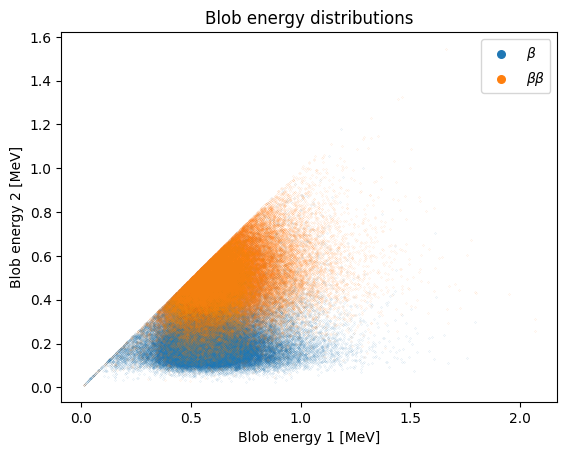

In [76]:
plt.figure()
plt.scatter(training_en_1[training_labels == 0], training_en_2[training_labels == 0], s = 0.003, alpha = 1)
plt.scatter(training_en_1[training_labels == 1], training_en_2[training_labels == 1], s = 0.003, alpha = 1)
plt.legend([r"$\beta$", r"$\beta\beta$"], markerscale=100)

plt.title("Blob energy distributions")
plt.xlabel("Blob energy 1 [MeV]")
plt.ylabel("Blob energy 2 [MeV]")

### Training a SVM for classification

In [81]:
from sklearn.svm import SVC
training_data = np.vstack([training_en_1, training_en_2]).T
val_data = np.vstack([val_en_1, val_en_2]).T
model = train_blobs(training_data[:5000], training_labels[:5000], "svm") # Using only 5e3 training events for computational tradeoff 
model.score(val_data, val_labels)
print("Model accuracy is ", model.score(val_data, val_labels))

[INFO] (quake.blob) Predicting classes with SVM


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .............................................C=0.01; total time=   0.7s
[CV] END .............................................C=0.01; total time=   0.7s
[CV] END .............................................C=0.01; total time=   0.6s
[CV] END ..............................................C=0.1; total time=   0.5s
[CV] END ..............................................C=0.1; total time=   0.5s
[CV] END ..............................................C=0.1; total time=   0.5s
[CV] END ................................................C=1; total time=   0.5s
[CV] END ................................................C=1; total time=   0.5s
[CV] END ................................................C=1; total time=   0.5s
[CV] END ...............................................C=10; total time=   0.6s
[CV] END ...............................................C=10; total time=   0.6s
[CV] END ........................................

[INFO] (quake.blob) {'C': 0.1}


Model accuracy is  0.8457540237301502


### Training a NP model for classification

In [80]:
from sklearn.svm import SVC
training_data = np.vstack([training_en_1, training_en_2]).T
val_data = np.vstack([val_en_1, val_en_2]).T
model = train_blobs(training_data, training_labels, "neyman_pearson")
print("Model accuracy is ", model.score(val_data, val_labels))

[INFO] (quake.blob) Predicting classes with Neyman-Pearson lemma


Model accuracy is  0.8448578700218662
